# Step 1: Parse Remix data to derive events by chain_id

In [1]:
import pandas as pd
import json
import re

In [2]:
path = 'data/transactions.json'
with open(path) as f:
    data = json.load(f)

In [3]:
records = []
for event_type, events in data.items():
    for event in events:
        records.append({
            'date': pd.to_datetime(event.get('Date')),            
            'event_type': event_type,
            'event_type_network': event_type.split(' - ')[0],            
            'event_type_category': event_type.split(' - ')[1],
            'event_count': int(event.get('nb_events'))
        })
df_events = pd.DataFrame(records)
df_events['chain_id'] = df_events['event_type_network'].str.extract(r'\((\d+)\)')
df_events.dropna(inplace=True)
df_events.tail()

,date,event_type,event_type_network,event_type_category,event_count,chain_id
41707,2025-09-08,Plume Testnet (98867) network - DeployContractTo,Plume Testnet (98867) network,DeployContractTo,7,98867
41708,2025-09-08,Unicorn Ultra Nebulas Testnet (2484) network -...,Unicorn Ultra Nebulas Testnet (2484) network,DeployContractTo,6,2484
41709,2025-09-08,Unicorn Ultra Nebulas Testnet (2484) network -...,Unicorn Ultra Nebulas Testnet (2484) network,transact,4,2484
41710,2025-09-08,Custom (11198111) network - call,Custom (11198111) network,call,28,11198111
41711,2025-09-08,Unicorn Ultra Nebulas Testnet (2484) network -...,Unicorn Ultra Nebulas Testnet (2484) network,call,19,2484


In [4]:
df_events['chain_id'].nunique()

1005

# Step 2: Join on chainlist and superchain chain_ids

In [5]:
from dotenv import load_dotenv
import os
from pyoso import Client

load_dotenv()
OSO_API_KEY = os.environ['OSO_API_KEY']
client = Client(api_key=OSO_API_KEY)

In [6]:
df_chains = client.to_pandas("""
SELECT
  CAST(c.chain_id AS varchar) AS chain_id,
  c.display_name,
  sc.chain IS NOT NULL AS is_superchain
FROM chains_v0 AS c
LEFT JOIN int_superchain_chain_names AS sc
  ON sc.chain = c.chain_name
""")
df_chains.tail()

,chain_id,display_name,is_superchain
38,690,Redstone,True
39,254,Swan Chain,True
40,480,World Chain,True
41,100,Gnosis,False
42,43114,Avalanche,False


In [7]:
df = df_events.merge(df_chains, on='chain_id')
df.tail()

,date,event_type,event_type_network,event_type_category,event_count,chain_id,display_name,is_superchain
7304,2025-07-29,Shape (360) network - DeployContractTo,Shape (360) network,DeployContractTo,9,360,Shape,True
7305,2025-08-24,Shape (360) network - DeployContractTo,Shape (360) network,DeployContractTo,2,360,Shape,True
7306,2025-07-20,Shape (360) network - transact,Shape (360) network,transact,96,360,Shape,True
7307,2025-07-29,Shape (360) network - transact,Shape (360) network,transact,16,360,Shape,True
7308,2025-08-24,Shape (360) network - call,Shape (360) network,call,3,360,Shape,True


# Step 3: Look at usage over time

In [8]:
import plotly.express as px

In [9]:
df_grp = df.groupby(['date', 'event_type_category', 'is_superchain'], as_index=False)['event_count'].sum()
df_grp.tail()

,date,event_type_category,is_superchain,event_count
1174,2025-09-08,DeployContractTo,True,391
1175,2025-09-08,call,False,690
1176,2025-09-08,call,True,419
1177,2025-09-08,transact,False,1173
1178,2025-09-08,transact,True,638


In [10]:
df_grp['event_type_category'].value_counts()

event_type_category
DeployContractTo    504
transact            338
call                337
Name: count, dtype: int64

In [11]:
df_filtered = df_grp.query("event_type_category == 'DeployContractTo'").sort_values('date')
fig = px.area(
    data_frame=df_filtered,
    x='date',
    y='event_count',
    color='is_superchain',
    category_orders={"is_superchain": [True, False]}
)

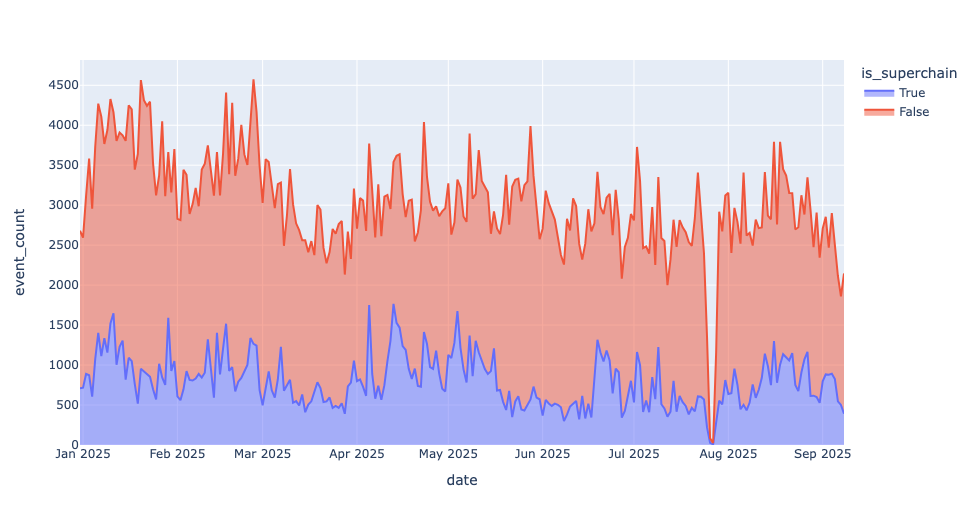

In [12]:
df_share = (
    df_filtered
    .assign(total=lambda d: d.groupby('date')['event_count'].transform('sum'))
    .assign(share=lambda d: d['event_count'] / d['total'] * 100)
)
fig = px.area(
    data_frame=df_share,
    x='date',
    y='share',
    color='is_superchain',
    category_orders={"is_superchain": [True, False]},
    labels={'share': 'Market Share (%)'}
)

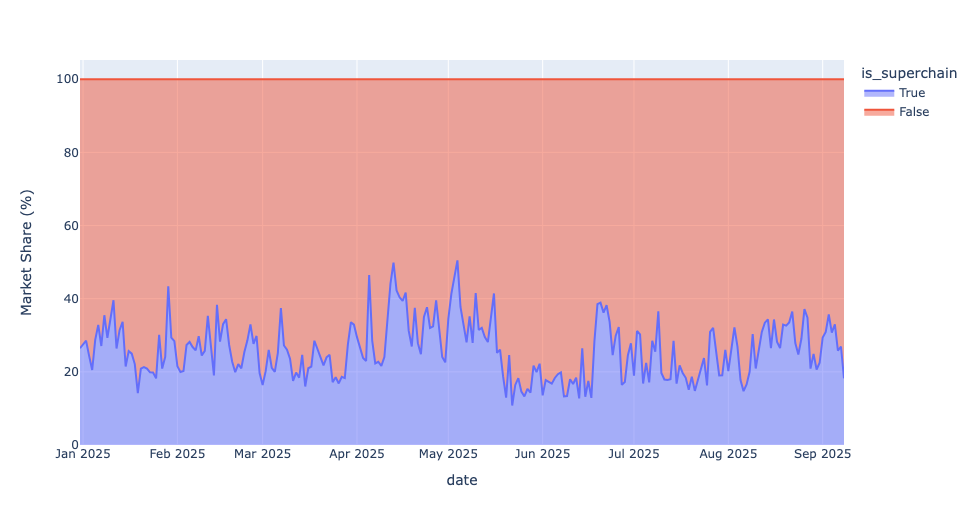

In [13]:
daily = (
    df_filtered.pivot_table(
        index='date',
        columns='is_superchain',
        values='event_count',
        aggfunc='sum'
    )
    .sort_index()
    .fillna(0)
)
share = daily.div(daily.sum(axis=1).replace(0, pd.NA), axis=0) * 100
share_30d = share.rolling('30D', min_periods=1).mean()
share_30d = share_30d.div(share_30d.sum(axis=1).replace(0, pd.NA), axis=0) * 100
df_long = (
    share_30d
    .reset_index()
    .melt(id_vars='date', var_name='is_superchain', value_name='share_30d')
)
fig = px.area(
    df_long,
    x='date',
    y='share_30d',
    color='is_superchain',
    category_orders={"is_superchain": [True, False]},
    labels={'share_30d':'Market Share (30d trailing avg, %)', 'date':'Date'}
)

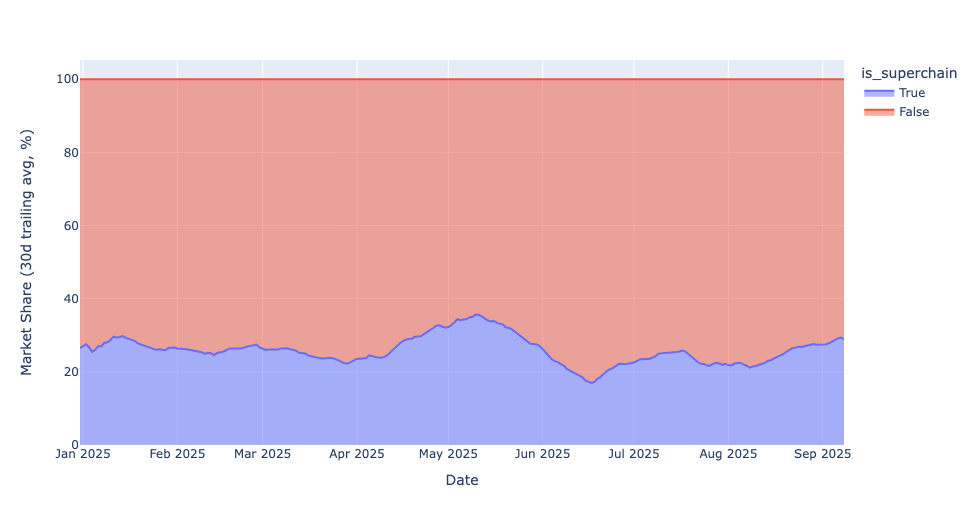